Peak: 96, Zero: 237
Embedding message of length: 100
Extracted message: 1011010110101101011010110101101011010110101101011010110101101011010110101101011010110101101011010110


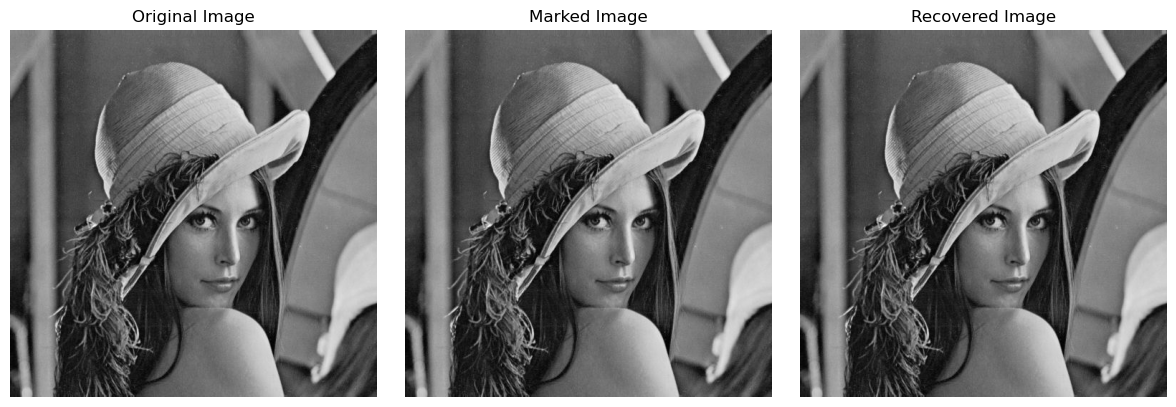

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_histogram(image_array):
    hist, _ = np.histogram(image_array, bins=256, range=(0, 256))
    return hist

def find_peak_and_zero(hist):
    peak = np.argmax(hist)
    zero_candidates = np.where(hist == 0)[0]
    if len(zero_candidates) == 0:
        raise ValueError("No zero point found in histogram.")
    zero = min(zero_candidates, key=lambda z: abs(z - peak))
    return peak, zero

def embed_data(image_array, data_bits, peak, zero):
    flat_img = image_array.flatten()
    modified = np.copy(flat_img)

    if zero > peak:
        shift_indices = np.where((flat_img > peak) & (flat_img < zero))[0]
        modified[shift_indices] += 1
    else:
        shift_indices = np.where((flat_img < peak) & (flat_img > zero))[0]
        modified[shift_indices] -= 1

    peak_indices = np.where(flat_img == peak)[0]
    for i, bit in enumerate(data_bits):
        if i >= len(peak_indices):
            break
        if bit == '1':
            modified[peak_indices[i]] = peak + 1 if zero > peak else peak - 1

    return modified.reshape(image_array.shape)

def extract_data(marked_image_array, data_length, peak, zero):
    flat_img = marked_image_array.flatten()
    extracted_bits = []
    recovery_indices = []

    val_1 = peak + 1 if zero > peak else peak - 1

    for idx, value in enumerate(flat_img):
        if value == peak:
            extracted_bits.append('0')
        elif value == val_1:
            extracted_bits.append('1')
            recovery_indices.append(idx)
        if len(extracted_bits) == data_length:
            break

    recovered = np.copy(flat_img)
    if zero > peak:
        shift_indices = np.where((flat_img > peak) & (flat_img <= zero))[0]
        recovered[shift_indices] -= 1
    else:
        shift_indices = np.where((flat_img < peak) & (flat_img >= zero))[0]
        recovered[shift_indices] += 1

    for idx in recovery_indices:
        recovered[idx] = peak

    return ''.join(extracted_bits), recovered.reshape(marked_image_array.shape)

def plot_images(original, marked, recovered):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(original, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Marked Image")
    plt.imshow(marked, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Recovered Image")
    plt.imshow(recovered, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.savefig("output.png")
    plt.show()

def main():
    image = cv2.imread("../test_imgs/lena.jpg", cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError("Image not found.")

    hist = compute_histogram(image)
    peak, zero = find_peak_and_zero(hist)
    print(f"Peak: {peak}, Zero: {zero}")

    peak_count = np.count_nonzero(image == peak)

    message = "1011010110" * 10  
    message = message[:peak_count]  
    print(f"Embedding message of length: {len(message)}")

    marked = embed_data(image, message, peak, zero)

    extracted_message, recovered = extract_data(marked, len(message), peak, zero)
    print("Extracted message:", extracted_message)

    plot_images(image, marked, recovered)

if __name__ == "__main__":
    main()
